<a href="https://colab.research.google.com/github/hectormelo/Machine-Learning-Techniques/blob/main/Taller_2/Taller_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219

Primer semestre - 2024



# **Taller 2**

GeoAlpes, una empresa líder en análisis geoespacial, está buscando mejorar sus técnicas de clasificación automática de imágenes satelitales. El objetivo es poder categorizar distintas características geográficas (como bosques, zonas industriales, zonas de cultivos permanentes, zonas residenciales y rios) con alta precisión y rapidez. Para lograrlo, están interesados en explorar las capacidades de los métodos ensemble.

1.  Exploración y Preparación de Datos

    -   Discuta las particularidades de las imágenes satelitales y sugiera técnicas extra de preprocesamiento de ser necesario.

2.  Implementación de Gradient Boosting

    -   Utilice Gradient Boosting como modelo base. Discuta las ventajas y desafíos de este método, y cómo afecta la precisión y robustez del clasificador. Además, compare el desempeño de Gradient Boosting con el modelo Random Forest presentado en la práctica, ¿logra observar mejoras significativas?

3. Implementación de un nuevo metodo Ensemble
    - Elija y presente un método ensemble de su preferencia.Introduzca y discuta el concepto del método elegido y cómo podría ser benéfico para la clasificación de imágenes satelitales.
    - Compare el desempeño de su método elegido con Gradient Boosting y el modelo Random Forest. Discuta las ventajas y desventajas de cada uno.

4.  Optimización y Ajuste

    -   Realice una búsqueda de los mejores hiperparámetros para mejorar el desempeño de cada uno de los modelos implementados (Grid Search).

Datos: [Enlace al sub conjunto del dataset de imágenes satelitales EuroSAT](https://github.com/hectormelo/Machine-Learning-Techniques/raw/main/Lab_2/EuroSAT3.zip)


In [32]:
import os
import numpy as np
from PIL import Image
from scipy import stats
from numpy import fliplr
from skimage.color import rgb2gray
from skimage.color import label2rgb
from skimage.transform import rotate
from skimage.segmentation import slic
from sklearn.model_selection import train_test_split

import pywt
import mahotas
import mahotas.features
from skimage.feature import local_binary_pattern

from sklearn.decomposition import PCA 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
def load_and_preprocess_images(folder, img_size=(64, 64), use_slic_segmentation=False, n_segments=30, compactness=10):
    images = []
    for filename in os.listdir(folder):
        image_path = os.path.join(folder, filename)
        image = Image.open(image_path)
        image = np.array(image.convert("RGB"))
        
        # normalization
        normalized_image = image / 255.0
        
        # data augmentation
        rotated_image = rotate(normalized_image, angle=90)
        flipped_image = fliplr(normalized_image)
        
        # apply SLIC
        if use_slic_segmentation:
            segments = slic(normalized_image, n_segments=n_segments, compactness=compactness, start_label=1)
            segmented_image = label2rgb(segments, normalized_image, kind='avg', bg_label=0)
            images.append(segmented_image)
        else:
            images.extend([normalized_image, rotated_image, flipped_image])
    
    return images

In [3]:
categories = ['Forest', 'Industrial', 'PermanentCrop', 'Residential', 'River']
base_path = './EuroSAT3/'

all_images = []
all_labels = []

for label, category in enumerate(categories):
    folder = os.path.join(base_path, category)
    category_images = load_and_preprocess_images(folder)
    all_images.extend(category_images)
    all_labels.extend([label] * len(category_images))

# Convertir listas a arrays de NumPy
all_images_np = np.array(all_images)
all_labels_np = np.array(all_labels)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(all_images_np, all_labels_np, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (9000, 64, 64, 3)
y_train shape: (9000,)
X_test shape: (2250, 64, 64, 3)
y_test shape: (2250,)


In [5]:
def extract_color_stats(image):
    features = []

    for channel in range(image.shape[-1]):
        channel_data = image[:, :, channel].ravel()
        
        mean = np.mean(channel_data)
        std = np.std(channel_data)
        var = np.var(channel_data)
        median = np.median(channel_data)
        
        mode_result = stats.mode(channel_data)
        mode = mode_result.mode
        
        min_val = np.min(channel_data)
        max_val = np.max(channel_data)
        percentile_25 = np.percentile(channel_data, 25)
        percentile_50 = np.percentile(channel_data, 50)
        percentile_75 = np.percentile(channel_data, 75)
        skewness = stats.skew(channel_data)
        kurtosis = stats.kurtosis(channel_data)
        data_range = max_val - min_val
        
        features.extend([
            mean, std, var, median, mode, min_val, max_val,
            percentile_25, percentile_50, percentile_75,
            skewness, kurtosis, data_range
        ])

    return features


def extract_color_histogram(image, bins=32, channel_range=(0, 256)):
    histogram = [np.histogram(image[:, :, i], bins=bins, range=channel_range)[0] for i in range(image.shape[-1])]
    return np.concatenate(histogram)


def extract_haralick_features(image):
    gray_image = rgb2gray(image)
    gray_image = (gray_image * 255).astype('uint8')

    features = mahotas.features.haralick(gray_image).mean(axis=0)
    
    return features


def extract_lbp_features(image, P=8, R=1, method='uniform'):

    image_gray = rgb2gray(image)
    lbp = local_binary_pattern(image_gray, P=P, R=R, method=method)

    lbp_hist, _ = np.histogram(lbp, density=True, bins=np.arange(0, P + 3), range=(0, P + 2))
    return lbp_hist


def extract_fft_features(image):

    fft_coefs = np.fft.fft2(rgb2gray(image))
    fft_abs = np.abs(fft_coefs)

    return np.mean(fft_abs), np.std(fft_abs)


def extract_wavelet_features(image, mode='haar', level=1):
    coeffs2 = pywt.dwt2(rgb2gray(image), mode)
    cA, (cH, cV, cD) = coeffs2

    return np.mean(cA), np.mean(cH), np.mean(cV), np.mean(cD)


In [6]:
def preprocess_image(image):
    color_stats_features = extract_color_stats(image)
    color_histogram_features = extract_color_histogram(image)
    haralick_features = extract_haralick_features(image)
    lbp_features = extract_lbp_features(image)
    fft_features = extract_fft_features(image)
    wlt_features = extract_wavelet_features(image)
    
    features = np.concatenate([
        color_stats_features, color_histogram_features, 
        haralick_features, lbp_features,
        fft_features, wlt_features
    ])
    return features

In [7]:
X_train_preprocessed = np.array([preprocess_image(image) for image in X_train])
X_test_preprocessed = np.array([preprocess_image(image) for image in X_test])

/home/leandro_driguez/github/Machine-Learning-Techniques/.venv/lib/python3.11/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [18]:
X_train_preprocessed.shape

(9000, 164)

In [19]:
pca = PCA(0.99).fit(X_train_preprocessed)

In [20]:
X_train_preprocessed_pca = pca.transform(X_train_preprocessed)

In [21]:
X_train_preprocessed_pca.shape

(9000, 1)

In [37]:
# param_grid = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.01, 0.1],
#     'max_depth': [3, 5],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'max_features': ['sqrt', 'log2', 0.5]
# }
param_grid = {'learning_rate': [0.1],
 'max_depth': [5],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1],
 'min_samples_split': [2],
 'n_estimators': [200]
}

gb_clf = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  23.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  23.4s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  24.6s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  27.0s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  28.1s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [5],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [200]},
             verbose=2)

In [38]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [25]:
X_test_preprocessed_pca = pca.transform(X_test_preprocessed)
X_test_preprocessed_pca.shape

(2250, 1)

In [39]:
y_pred = grid_search.predict(X_test_preprocessed)

Precisión de Gradient Boosting: 0.9973333333333333

Informe de clasificación de Gradient Boosting:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       463
           1       0.99      0.99      0.99       475
           2       1.00      1.00      1.00       432
           3       0.99      1.00      1.00       437
           4       1.00      0.99      1.00       443

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250


Matriz de confusión de Gradient Boosting:


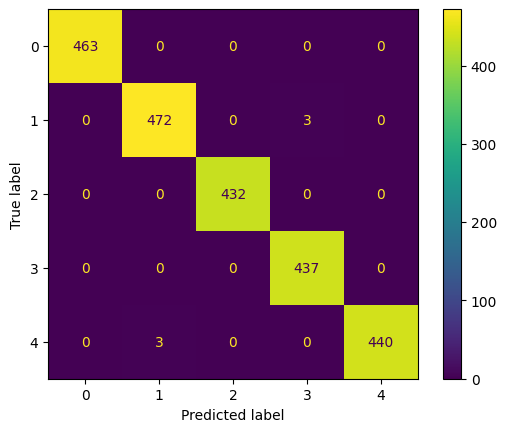

In [40]:
# Precisión
print("Precisión de Gradient Boosting:", accuracy_score(y_test, y_pred))

# Informe de clasificación
print("\nInforme de clasificación de Gradient Boosting:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("\nMatriz de confusión de Gradient Boosting:")
cm_rf = confusion_matrix(y_test, y_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()